In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings('ignore')

if not os.path.abspath(os.pardir+ '/src') in sys.path:
    sys.path.append(os.path.abspath(os.pardir) + '/src')

from data_reader import read_data
from features_processor import FeaturesProcessor
from ml_experiments import *
from config import *

### Read Data and prepare features

In [3]:
train_df = read_data(DATA_PATH + TRAIN_FNAME, DATA_PATH + METADATA_FNAME, drop_cols = IGNORE_FEATURES)
test_df = read_data(DATA_PATH + TEST_FNAME, DATA_PATH + METADATA_FNAME, drop_cols = IGNORE_FEATURES)

test_df.shape, train_df.shape

Read input data file ../data/census_income_learn.csv
Read metadata file ../data/census_income_metadata.txt
Couldnt parse line 
Mapped columns
Read input data file ../data/census_income_test.csv
Read metadata file ../data/census_income_metadata.txt
Couldnt parse line 
Mapped columns


((99762, 41), (199523, 41))

In [4]:
fprocessor = FeaturesProcessor('OHE')

encoded_train_df, encoders = fprocessor.transform_features(train_df, make_calculated = True)
encoded_test_df, encoders = fprocessor.transform_features(test_df, make_calculated = True)

encoded_train_df, encoded_val_df = train_test_split(encoded_train_df, test_size=0.1, random_state=32)


encoded_train_df.shape, encoded_val_df.shape, encoded_test_df.shape

Scaling Numerical Features
Missing max values to scale in 0..1 range, will calculate from current data
Encoders not found, creating new encoders
Scaling Numerical Features
Encoders were found, using existing encoders


((179570, 424), (19953, 424), (99762, 424))

### First try models with new calculated  features

In [6]:
# feature names
feat_names = [col for col in encoded_train_df.columns if (col != TARGET_NAME)]


# given previous experiment only keep best version of each model

models = [ #LogisticRegression(C=1.0, class_weight='balanced', max_iter=200, n_jobs = N_JOBS), #strong regularization, class balancing
          #LogisticRegression(C=1.0, class_weight='balanced', max_iter=500, n_jobs = N_JOBS), 
          #LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, n_jobs = N_JOBS), 
          #LogisticRegression(C=0.1, class_weight='balanced', max_iter=200, n_jobs = N_JOBS), #weak regularization, class balancing
          #LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, n_jobs = N_JOBS), 
          LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, n_jobs = N_JOBS, random_state=32), 

          #DecisionTreeClassifier(max_depth=4, class_weight='balanced'),
          #DecisionTreeClassifier(max_depth=7, class_weight='balanced'),
          #DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
          DecisionTreeClassifier(max_depth=13, class_weight='balanced', random_state=32),

          #RandomForestClassifier(n_estimators=500, max_depth=3, max_features=0.3, n_jobs=N_JOBS), #try not very deep trees
          #RandomForestClassifier(n_estimators=1000, max_depth=3, max_features=0.3, n_jobs=N_JOBS),
          RandomForestClassifier(n_estimators=1500, max_depth=3, max_features=0.3, n_jobs=N_JOBS, random_state=32),
          #RandomForestClassifier(n_estimators=500, max_depth=6, n_jobs=N_JOBS), #try deeper trees
          #RandomForestClassifier(n_estimators=1000, max_depth=6, n_jobs=N_JOBS),
          #RandomForestClassifier(n_estimators=1500, max_depth=6, n_jobs=N_JOBS),
    
          #CatBoostClassifier(iterations = 500, task_type = 'GPU' if GPU else 'CPU'),
          CatBoostClassifier(iterations = 1000, task_type = 'GPU' if GPU else 'CPU', silent = True, random_state=32),
          #CatBoostClassifier(iterations = 1500, task_type = 'GPU' if GPU else 'CPU'),
          #CatBoostClassifier(iterations = 2000, task_type = 'GPU' if GPU else 'CPU'),
         
         
         ]

exp_name_base = 'feats_eng'
#folder to store artifacts
#folder to store artifacts
if not os.path.isdir(MODELS_PATH + exp_name_base):
    os.mkdir(MODELS_PATH + exp_name_base)

for model in models:

    model.fit(encoded_train_df[feat_names], encoded_train_df[TARGET_NAME])

    metrics = evaluate_model(model.predict(encoded_val_df[feat_names]), encoded_val_df[TARGET_NAME])
    model_name = get_model_string(model)
    
    log_model(exp_name_base, model_name,
             MODELS_PATH + MODELS_LOG_FNAME,
             metrics)

    save_model_pickle(model, MODELS_PATH + f'{exp_name_base}/' + model_name[:100] + '.pkl')
    print(model_name)
    print(metrics)
    print()



CatBoostClassifier(iterations=1000,silent=True,task_type=CPU,random_state=32)
[0.602990834539315, 0.500801282051282, 0.7575757575757576, '[[18505   623]\n [  200   625]]']



In [7]:
print(classification_report(model.predict(encoded_test_df[feat_names]), encoded_test_df[TARGET_NAME]))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     95865
           1       0.48      0.77      0.59      3897

    accuracy                           0.96     99762
   macro avg       0.74      0.87      0.79     99762
weighted avg       0.97      0.96      0.96     99762



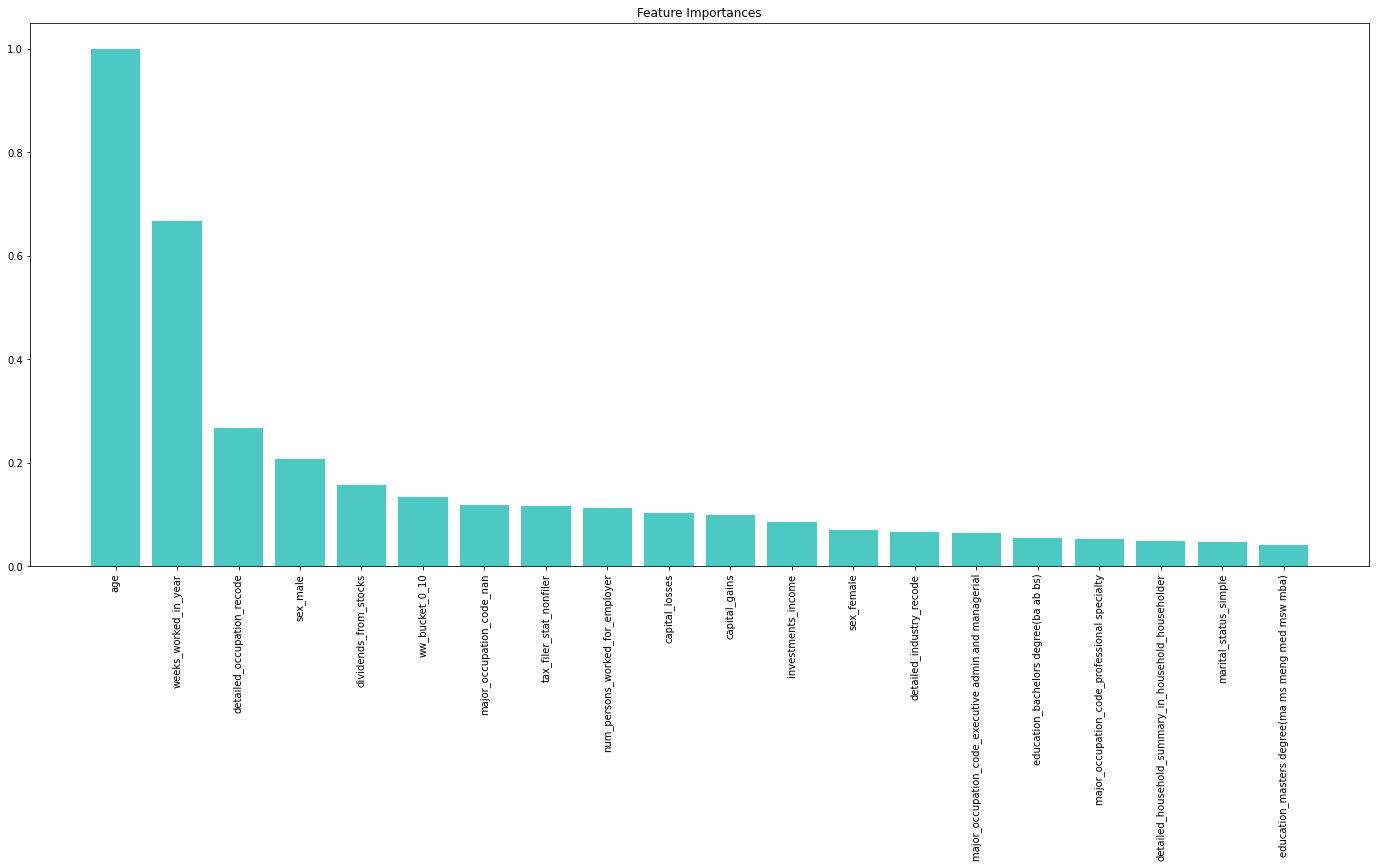

In [10]:
PLOT_MAX = 20
importances = sorted([(name,imp/max(model.feature_importances_)) for name, imp in zip(feat_names, model.feature_importances_)], 
                     key = lambda x:-x[1])[:PLOT_MAX]

plt.figure(figsize=(24, 10))
plt.bar([e[0] for e in importances], [e[1] for e in importances], color = COLORS[0])
plt.title('Feature Importances')
plt.xticks(rotation = 90)
plt.show()

### Then we can Check if Features Selection brings any benefits

In [10]:
best_model = model

for max_n_features in reversed([10, 20, 30, 60, 100, 200, 300]):
    
    importances = sorted([(name,imp/max(best_model.feature_importances_)) for name, imp in zip(feat_names, best_model.feature_importances_)], 
                         key = lambda x:-x[1])[:max_n_features]
    
    importances = set([i[0] for i in importances])
    
    # feature names
    feat_names = [col for col in encoded_train_df.columns if ((col != TARGET_NAME) and (col in importances))]
    
    
    # given previous experiment only keep best version of each model
    
    models = [ #LogisticRegression(C=1.0, class_weight='balanced', max_iter=200, n_jobs = N_JOBS), #strong regularization, class balancing
              #LogisticRegression(C=1.0, class_weight='balanced', max_iter=500, n_jobs = N_JOBS), 
              #LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, n_jobs = N_JOBS), 
              #LogisticRegression(C=0.1, class_weight='balanced', max_iter=200, n_jobs = N_JOBS), #weak regularization, class balancing
              #LogisticRegression(C=0.1, class_weight='balanced', max_iter=500, n_jobs = N_JOBS), 
              LogisticRegression(C=0.1, class_weight='balanced', max_iter=1000, n_jobs = N_JOBS, random_state=32), 
    
              #DecisionTreeClassifier(max_depth=4, class_weight='balanced'),
              #DecisionTreeClassifier(max_depth=7, class_weight='balanced'),
              #DecisionTreeClassifier(max_depth=10, class_weight='balanced'),
              DecisionTreeClassifier(max_depth=13, class_weight='balanced', random_state=32),
    
              #RandomForestClassifier(n_estimators=500, max_depth=3, max_features=0.3, n_jobs=N_JOBS), #try not very deep trees
              #RandomForestClassifier(n_estimators=1000, max_depth=3, max_features=0.3, n_jobs=N_JOBS),
              RandomForestClassifier(n_estimators=1500, max_depth=3, max_features=0.3, n_jobs=N_JOBS, random_state=32),
              #RandomForestClassifier(n_estimators=500, max_depth=6, n_jobs=N_JOBS), #try deeper trees
              #RandomForestClassifier(n_estimators=1000, max_depth=6, n_jobs=N_JOBS),
              #RandomForestClassifier(n_estimators=1500, max_depth=6, n_jobs=N_JOBS),
        
              #CatBoostClassifier(iterations = 500, task_type = 'GPU' if GPU else 'CPU'),
              CatBoostClassifier(iterations = 1000, task_type = 'GPU' if GPU else 'CPU', silent = True, random_state=32),
              #CatBoostClassifier(iterations = 1500, task_type = 'GPU' if GPU else 'CPU'),
              #CatBoostClassifier(iterations = 2000, task_type = 'GPU' if GPU else 'CPU'),
             
             
             ]
    
    exp_name_base = f'feats_sel_top{max_n_features}'
    #folder to store artifacts
    #folder to store artifacts
    if not os.path.isdir(MODELS_PATH + exp_name_base):
        os.mkdir(MODELS_PATH + exp_name_base)
    
    for model in models:
    
        model.fit(encoded_train_df[feat_names], encoded_train_df[TARGET_NAME])
    
        metrics = evaluate_model(model.predict(encoded_val_df[feat_names]), encoded_val_df[TARGET_NAME])
        model_name = get_model_string(model)
        
        log_model(exp_name_base, model_name,
                 MODELS_PATH + MODELS_LOG_FNAME,
                 metrics)
    
        save_model_pickle(model, MODELS_PATH + f'{exp_name_base}/' + model_name[:150] + '.pkl')
        print(model_name)
        print(metrics)
        print()


    print('-'*50, encoded_val_df[feat_names].shape)


LogisticRegression(C=0.1,class_weight=balanced,dual=False,fit_intercept=True,intercept_scaling=1,l1_ratio=None,max_iter=1000,multi_class=deprecated,n_jobs=6,penalty=l2,random_state=32,solver=lbfgs,tol=0.0001,verbose=0,warm_start=False)
[0.43346303501945527, 0.8926282051282052, 0.28622816032887977, '[[15927   134]\n [ 2778  1114]]']

DecisionTreeClassifier(ccp_alpha=0.0,class_weight=balanced,criterion=gini,max_depth=13,max_features=None,max_leaf_nodes=None,min_impurity_decrease=0.0,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,monotonic_cst=None,random_state=32,splitter=best)
[0.42735042735042733, 0.8413461538461539, 0.2864157119476268, '[[16089   198]\n [ 2616  1050]]']

RandomForestClassifier(bootstrap=True,ccp_alpha=0.0,class_weight=None,criterion=gini,max_depth=3,max_features=0.3,max_leaf_nodes=None,max_samples=None,min_impurity_decrease=0.0,min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,monotonic_cst=None,n_estimators=1500,n_jobs=6,oob_sco